In [1]:
library(tidyverse)
library(glmnet)
library(superheat)
library(grid)

source('../utils/plottingUtilities.R')

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [3]:
# this is the original late data
# stored in "late"
load('../data/lateData.Rdata')

# Plot dictionaries

In [4]:
# multiplot <- function(..., plotlist=NULL, cols=1, layout=NULL, widths=NULL, heights=NULL, 
#                       title=NULL, titlefont = "", titleface = 1, titlesize = 16) {
  
#   # Make a list from the ... arguments and plotlist
#   plots <- c(list(...), plotlist)
  
#   numPlots = length(plots)
  
#   # If layout is NULL, then use 'cols' to determine layout
#   if (is.null(layout)) {
#     # Make the panel
#     # ncol: Number of columns of plots
#     # nrow: Number of rows needed, calculated from # of cols
#     layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
#                      ncol = cols, nrow = ceiling(numPlots/cols))
#   }
  
#   if (!is.null(title)) { # Add a narrow row at the top for the title
#     layout <- rbind(rep(0,ncol(layout)),layout)
#     if (is.null(heights)) {
#       plotrows <- nrow(layout)-1
#       rowheights <- c(0.1, rep(1,plotrows)/plotrows)
#     } else {
#       rowheights <- c(0.1, heights/sum(heights))
#     }
#   } else {
#     if (is.null(heights)) {
#       rowheights <- rep(1,nrow(layout))  
#     } else {
#       rowheights <- heights
#     }
#   }
  
#   if (is.null(widths)) {
#     colwidths <- rep(1, cols)
#   } else {
#     colwidths <- widths
#   }
  
#   if (numPlots==1) {
    
#     return(plots[[1]] + labs(title=title))
    
#   } else {
#     # Set up the page
#     grid.newpage()
#     pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout), 
#                                                widths=colwidths, 
#                                                heights=rowheights)))
    
#     # Make each plot, in the correct location
#     for (i in 1:numPlots) {
#       # Get the i,j matrix positions of the regions that contain this subplot
#       matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
      
#       print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
#                                       layout.pos.col = matchidx$col))
#     }
    
#     if (!is.null(title)) {
#       grid.text(title, vp = viewport(layout.pos.row = 1
#                                      , layout.pos.col = 1:ncol(layout)), 
#                 gp = gpar(fontfamily = titlefont, fontface = titleface, 
#                           fontsize = titlesize))
#     }
    
#   }
# return(invisible(NULL))
# }


In [5]:
# plot_all_PPs <- function(dict, template, reference = NULL, ncols = 5){
  
#   if(is.null(reference)){
#     perm <- seq(1, dim(dict)[2], by= 1)
#   }else{
#     # we sort the dictionary by comparing it with a reference dictionary
#     remove_col <- c()
#     perm <- c()
#     for(i in 1:dim(reference)[2]){
#         diff <- t(as.matrix(dict)) %*% reference[, i]
#         perm_ <- order(diff, decreasing = TRUE)

#         perm_ <- perm_[!(perm_ %in% remove_col)]
#         perm <- c(perm, perm_[1])
#         remove_col <- c(remove_col, perm_[1])
#     }      
    
#   }

#     p <- list()
#       for(i in 1:dim(dict)[2]){
#         p[[i]] <- plotImg(dict[, perm[i]], late$template, FALSE)
#       }

#       plot <- multiplot(plotlist = p, cols = ncols)

#     return(perm)
# }

## The original staNMF fit  

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19

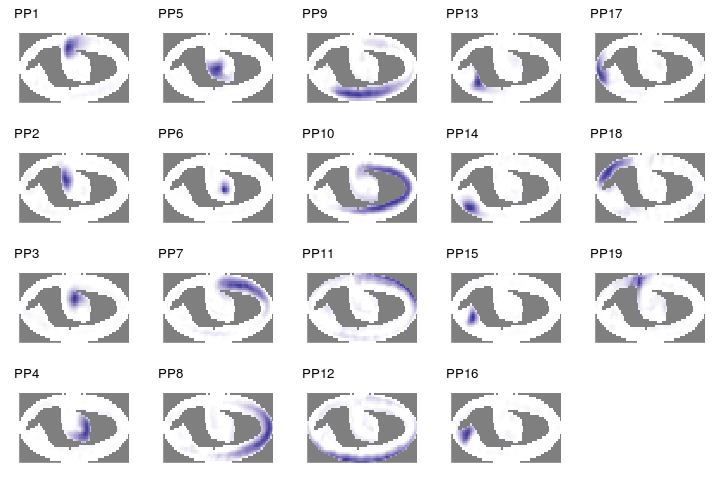

In [6]:
# NOTE PPs are column ordered
options(repr.plot.width = 6, repr.plot.height = 4)
plot_all_PPs(late$dict, late$template)

# get genes with replicates 

In [7]:
table_genes <- table(late$gene.names)
repeated_genes <- names(table_genes)[table_genes > 1]
n_repeated_genes <- length(repeated_genes)

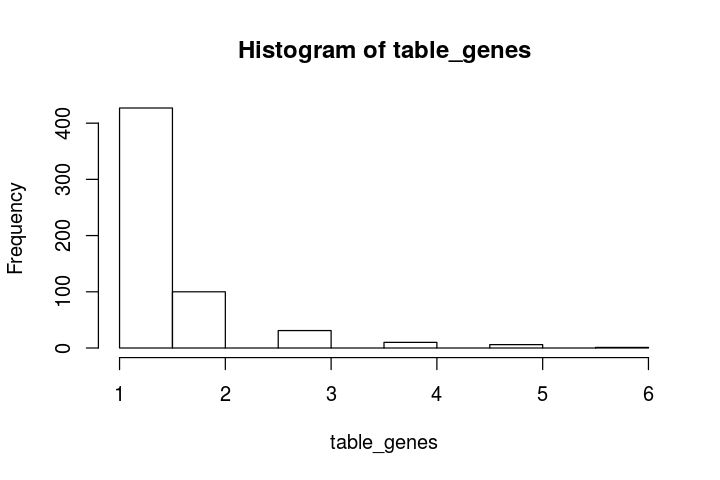

In [8]:
# distribution of number of replicates
hist(table_genes)

# get correlations

In [9]:
get_all_pairwise_correlations <- function(x){
    # x is matrix of pixel values
    # each column is a vector of pixel values corresponding to a replicate
    # returns all pairwise correlations

    correlations <- cor(x)
    upper_triangular_indx <- row(correlations) <= (col(correlations) - 1)

    return(correlations[upper_triangular_indx])
}


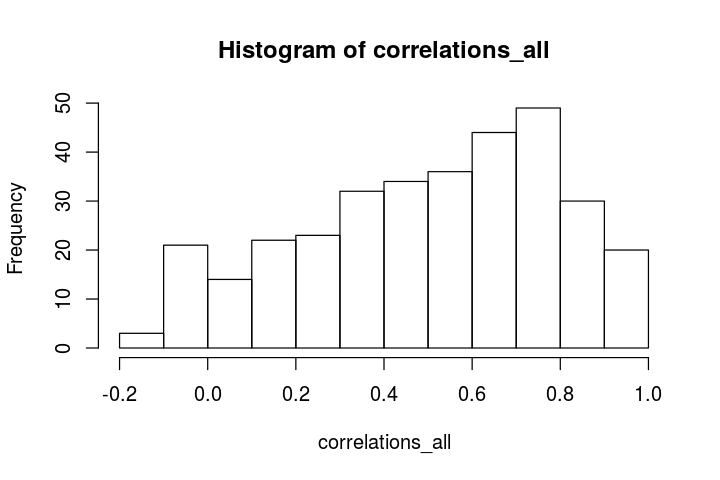

In [10]:
n_repeated_genes <- length(repeated_genes)

correlations_all <- c()

for(i in 1:n_repeated_genes){
    x <- late$x[, colnames(late$x) == repeated_genes[i]]
    
    stopifnot(dim(x)[2] > 1) # check gene is actually repeated
    
    correlations_all <- c(correlations_all, get_all_pairwise_correlations(x))
}


hist(correlations_all)

# Pick out problematic replicates

In [11]:
# pick a threshold 
thresh <- 0.5

In [12]:
which_problematic <- c()
for(i in 1:n_repeated_genes){
    x <- late$x[, colnames(late$x) == repeated_genes[i]]
    
    stopifnot(dim(x)[2] > 1) # check gene is actually repeated
    
    correlations <- get_all_pairwise_correlations(x)
    
    if(any(correlations < thresh)){
        which_problematic <- c(which_problematic, repeated_genes[i])
    }
}


In [13]:
which_problematic

[1] "Aldh"      "Alhambra"  "Ance"      "aret"      "brk"       "btn"      
 [7] "CG10053"   "CG12489"   "CG12744"   "CG12909"   "CG13624"   "CG1598"   
[13] "CG3184"    "CG3249"    "CG3838"    "CG4854"    "CG5888"    "CG6070"   
[19] "CG6206"    "CG6563"    "CG8066"    "CG9663"    "cic"       "comm2"    
[25] "disco"     "Dp"        "dpn"       "Dr"        "ebi"       "en"       
[31] "esg"       "E(spl)"    "eya"       "gcm"       "Grip"      "HGTX"     
[37] "HLHm5"     "ImpE2"     "ind"       "inx2"      "kni"       "l(3)82Fd" 
[43] "l(3)IX-14" "lab"       "Lac"       "loner"     "mael"      "Mef2"     
[49] "Mes2"      "Mipp1"     "Nap1"      "nerfin-1"  "noc"       "nrv2"     
[55] "Optix"     "Oscillin"  "otp"       "pnt"       "prd"       "Pros54"   
[61] "rib"       "sc"        "slp1"      "srp"       "Sulf1"     "su(r)"    
[67] "term"      "toy"       "ttk"       "tup"       "twi"       "Ubx"      
[73] "unpg"

In [14]:
sum(table_genes[names(table_genes) %in% which_problematic] == 3)

[1] 18

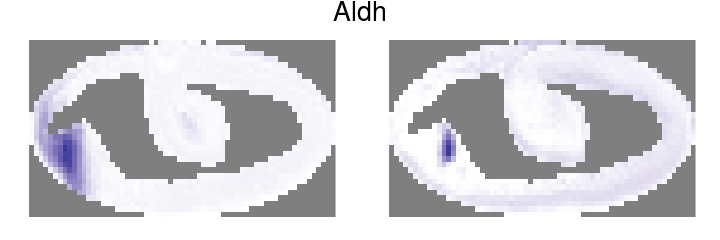

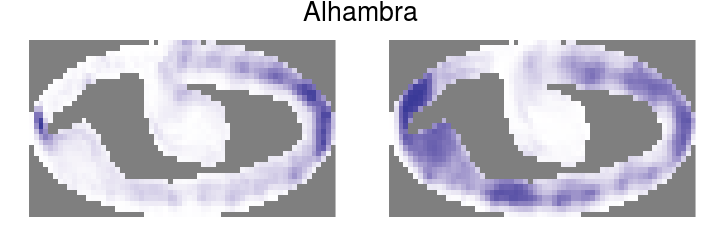

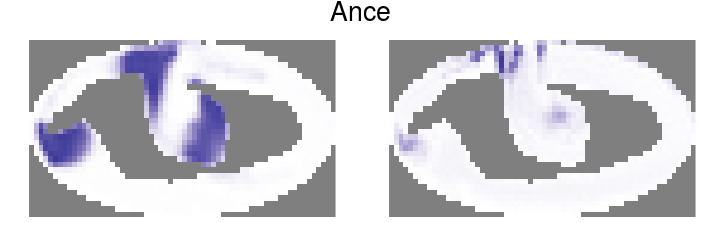

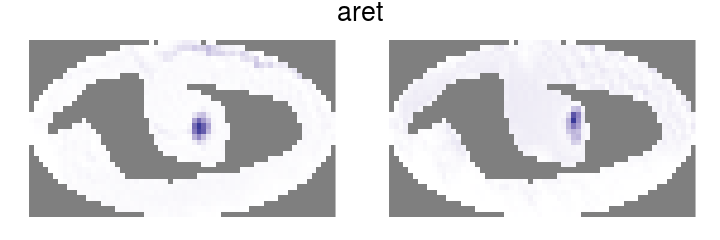

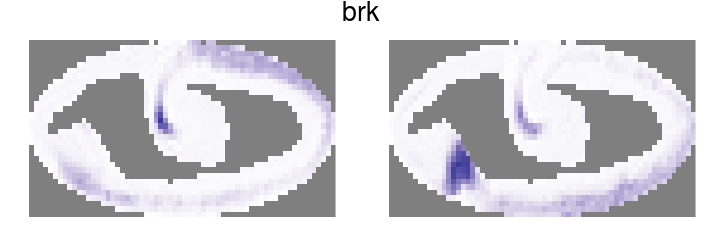

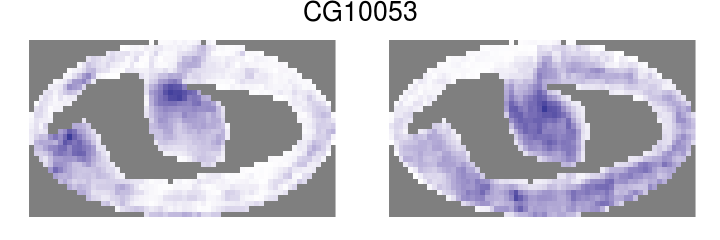

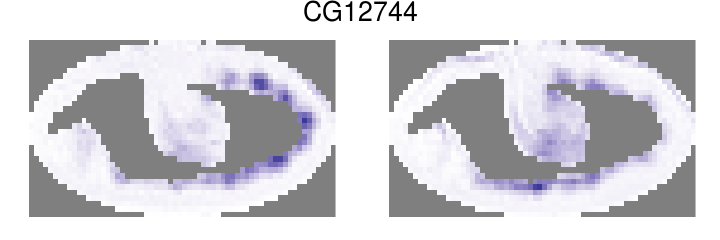

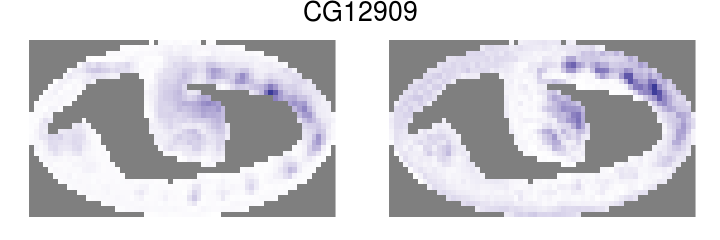

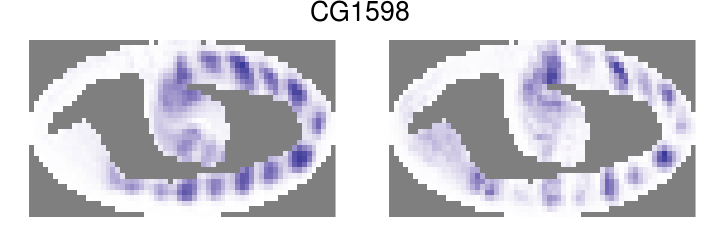

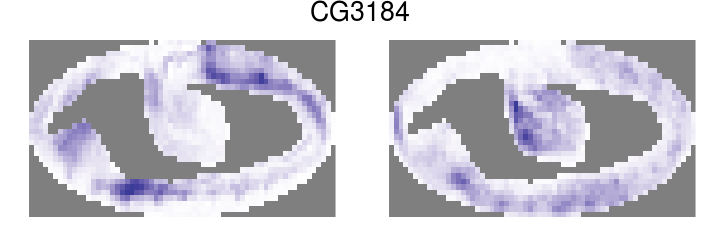

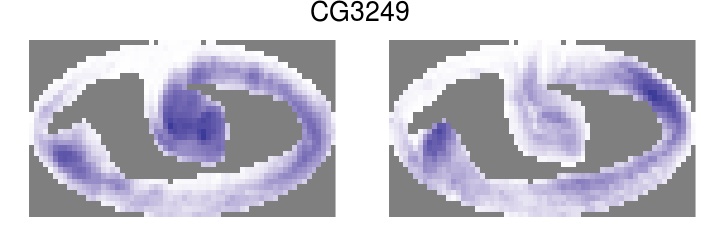

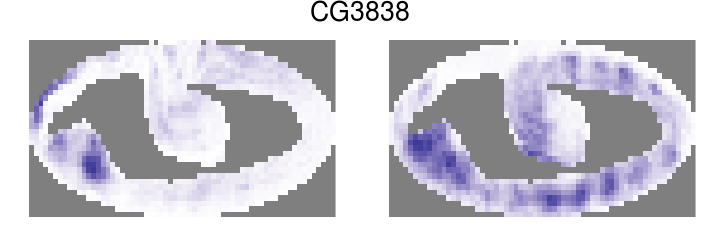

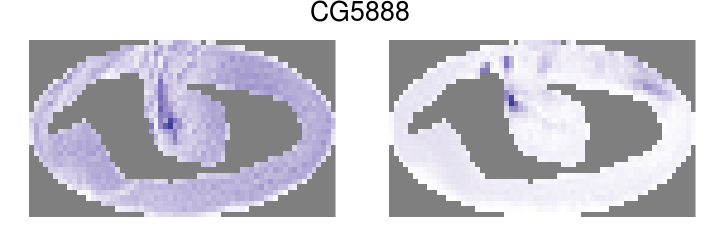

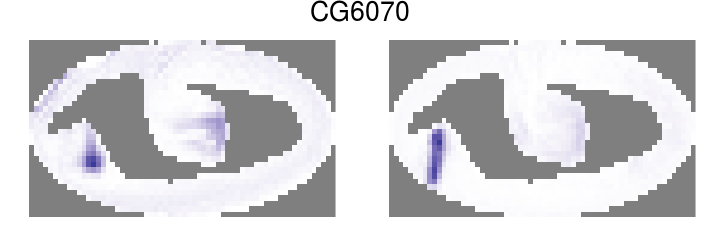

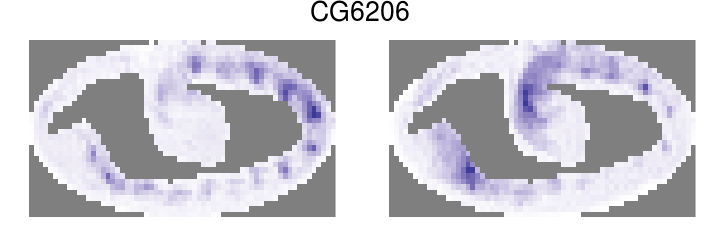

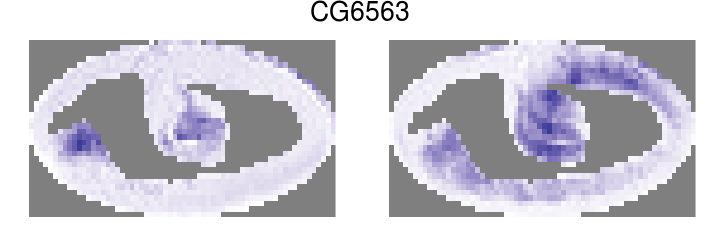

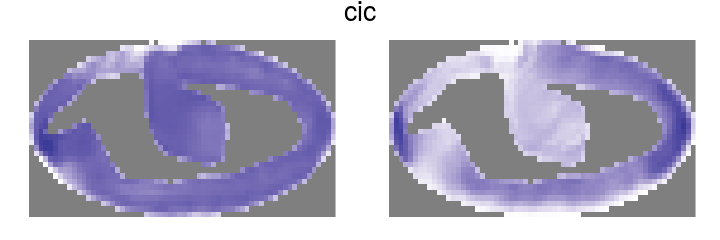

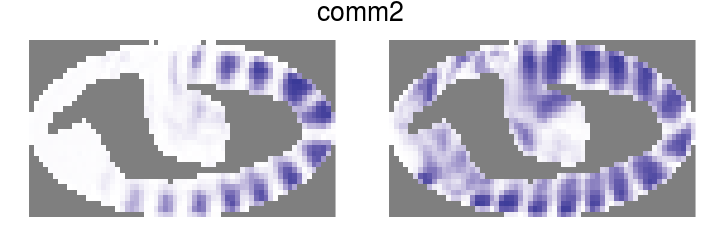

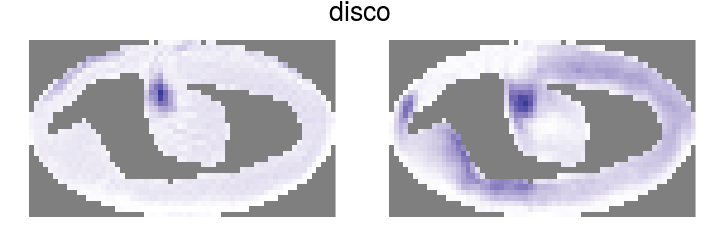

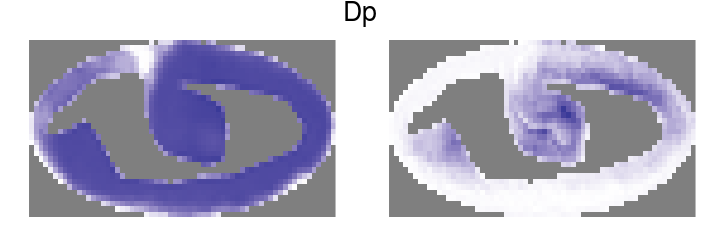

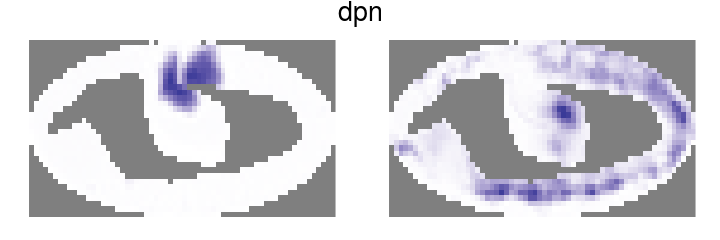

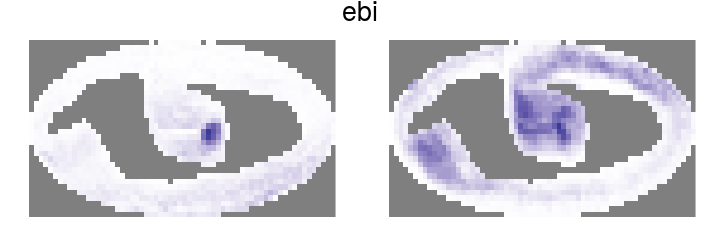

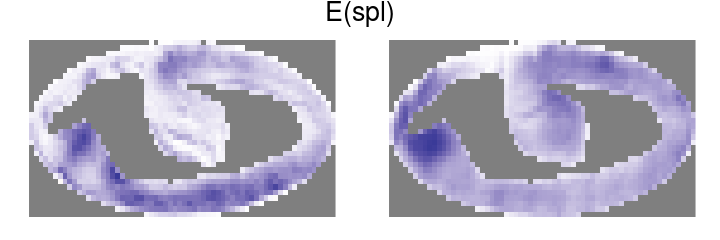

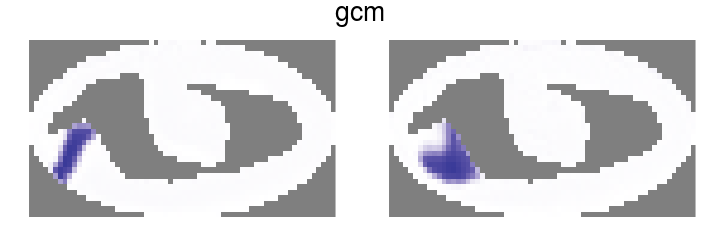

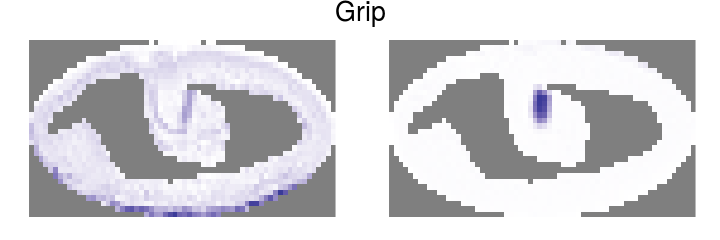

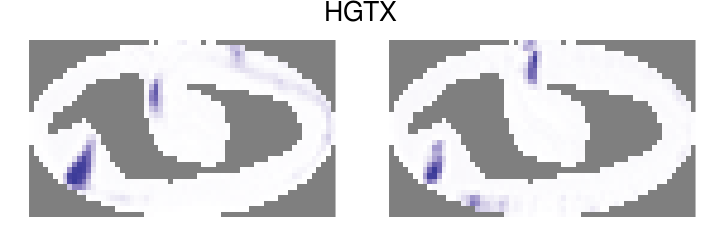

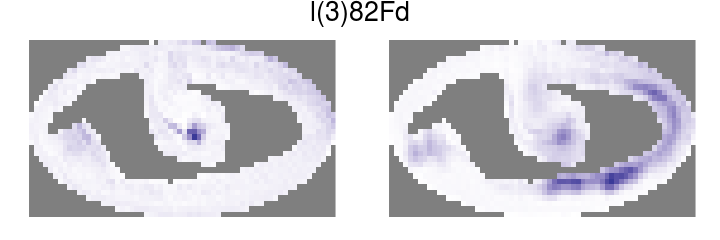

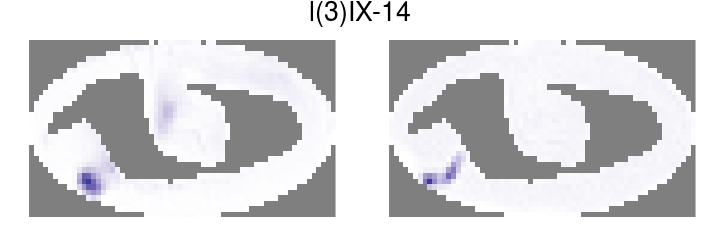

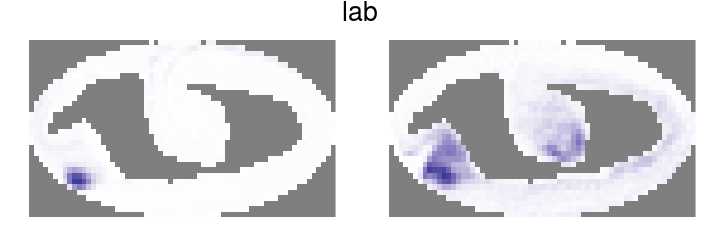

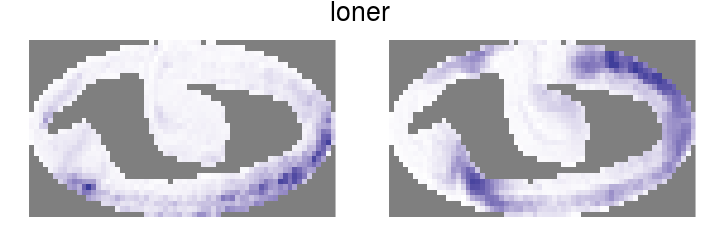

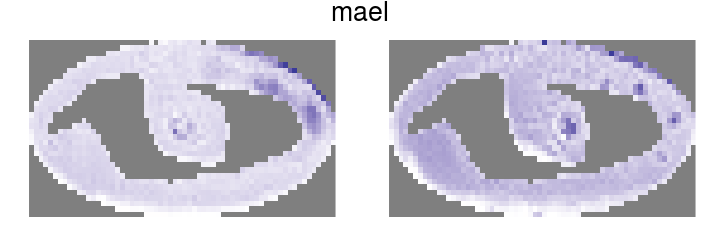

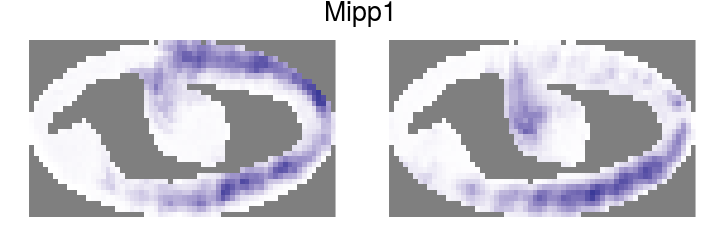

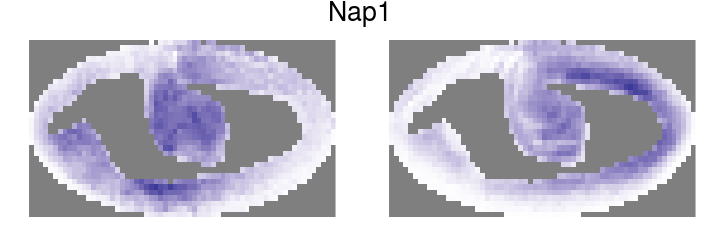

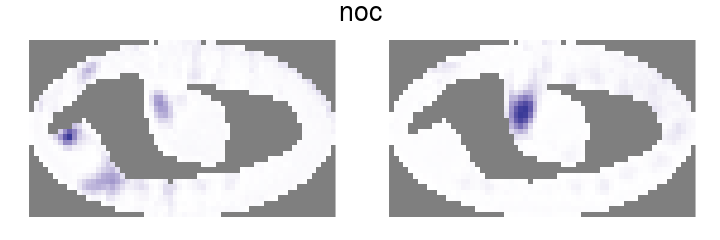

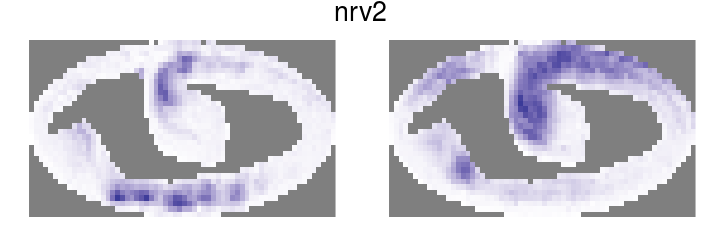

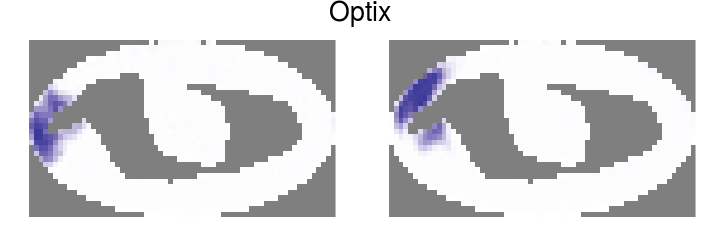

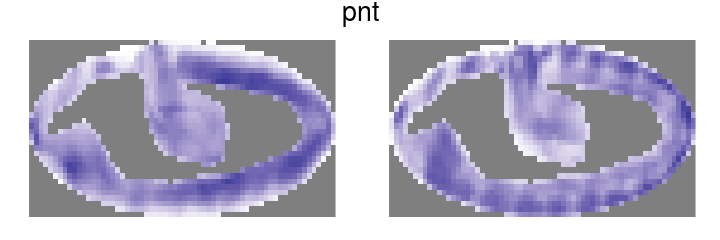

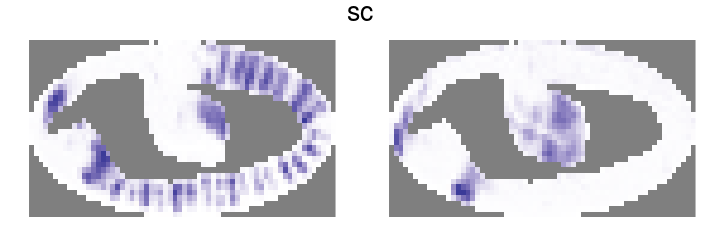

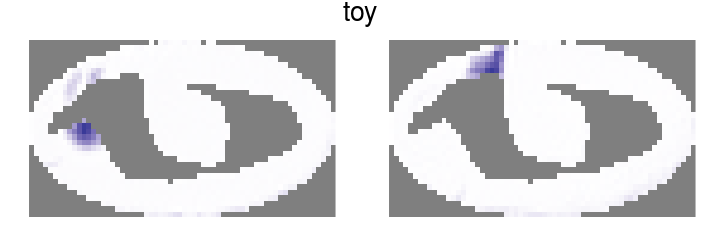

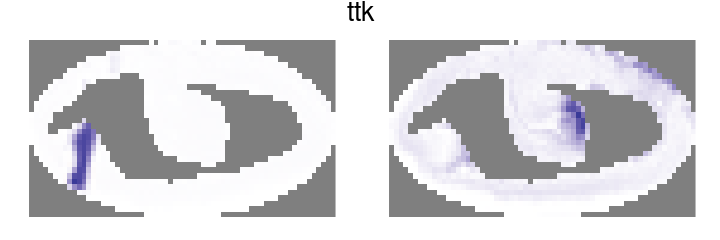

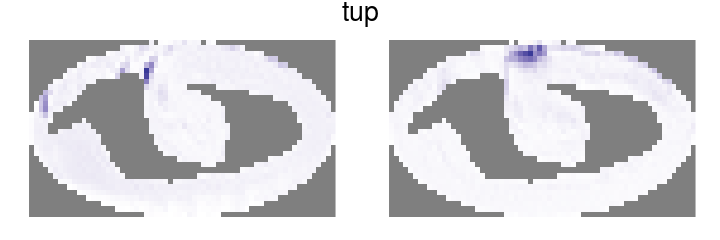

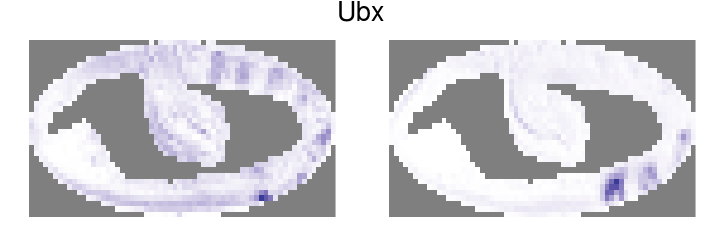

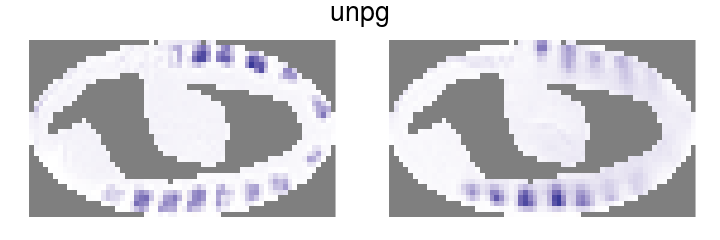

In [15]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) > 2){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 6, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


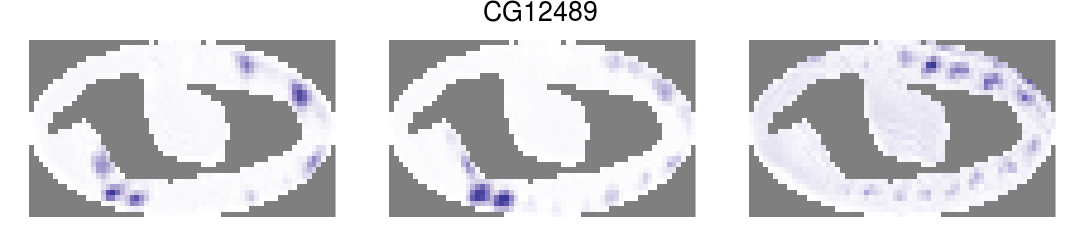

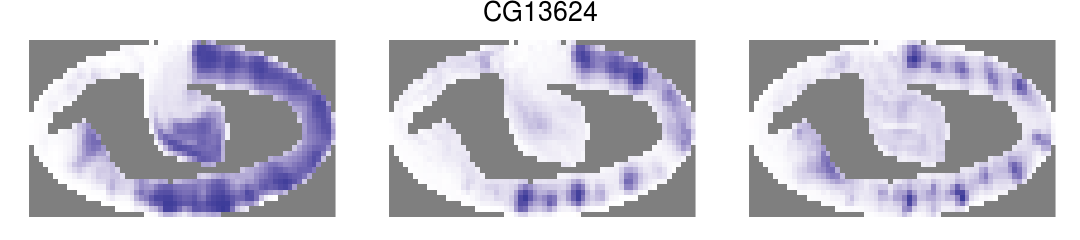

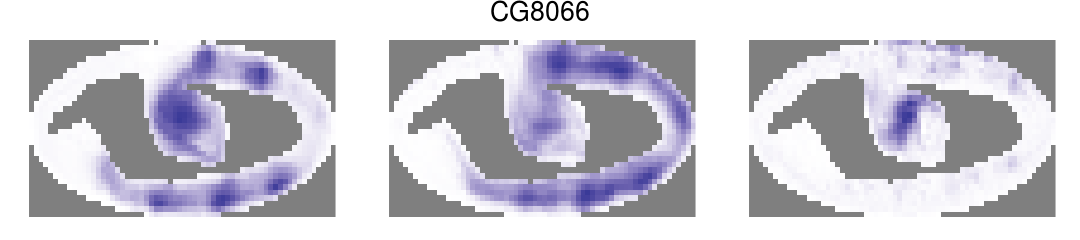

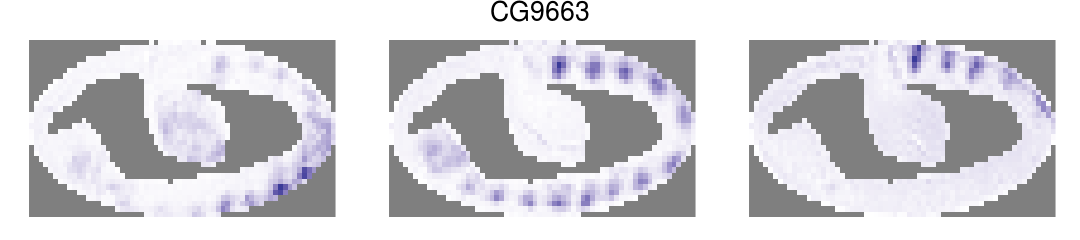

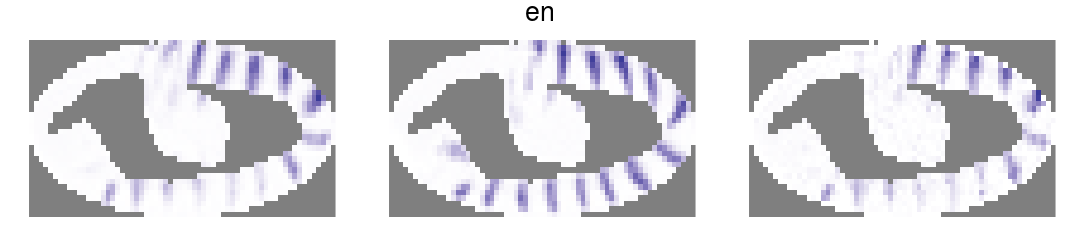

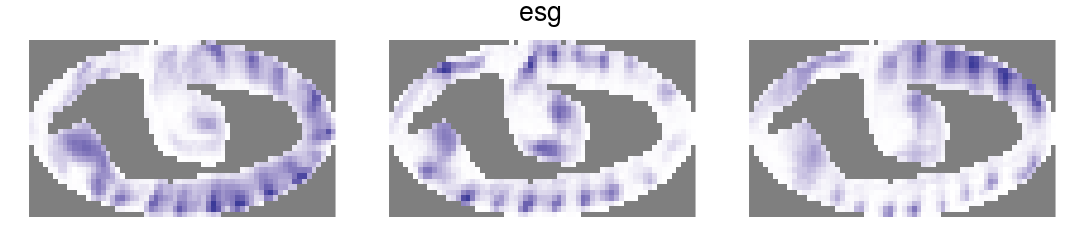

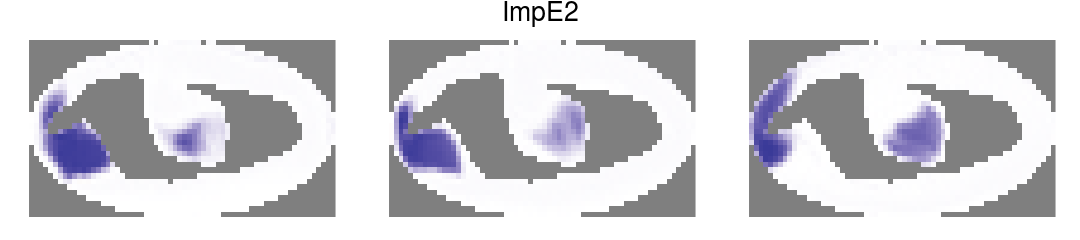

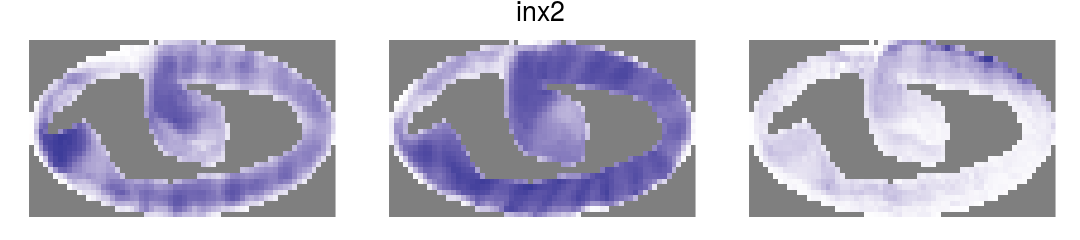

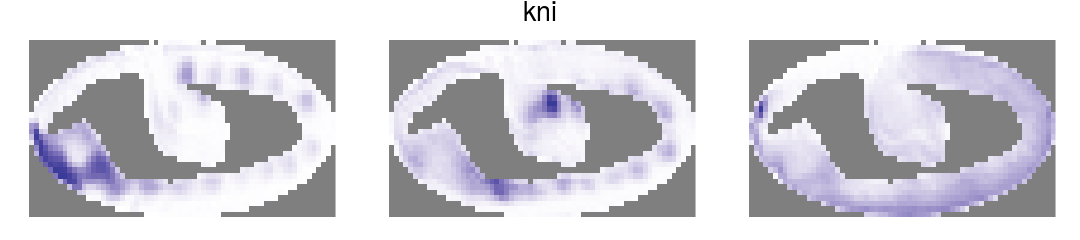

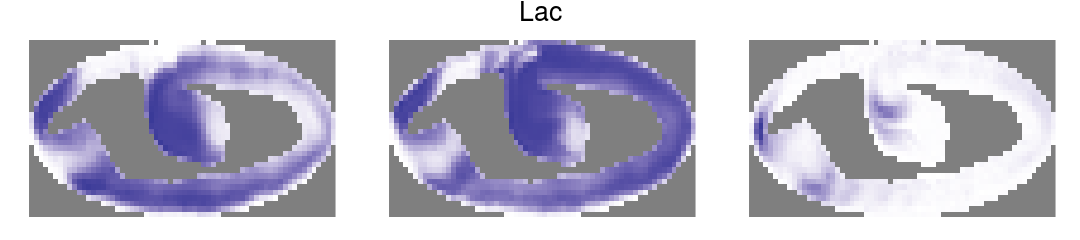

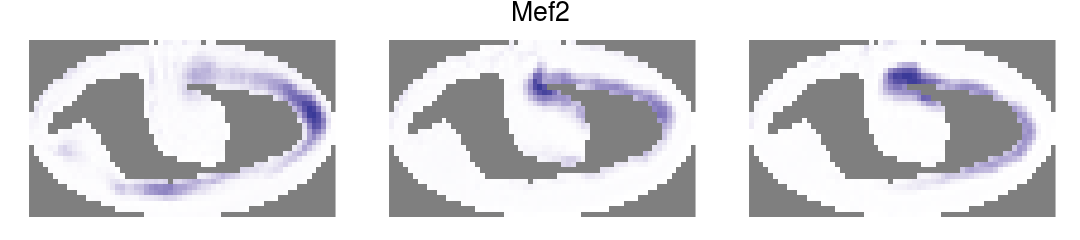

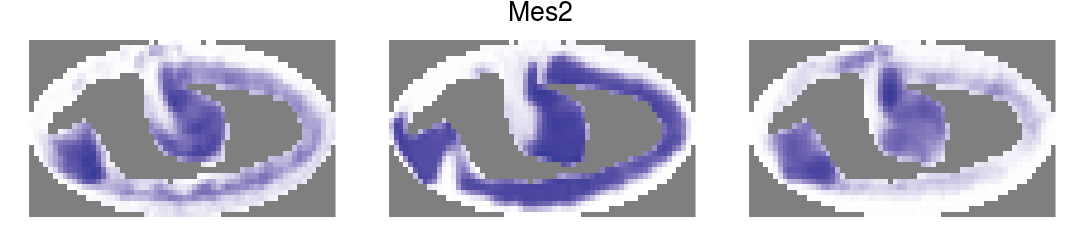

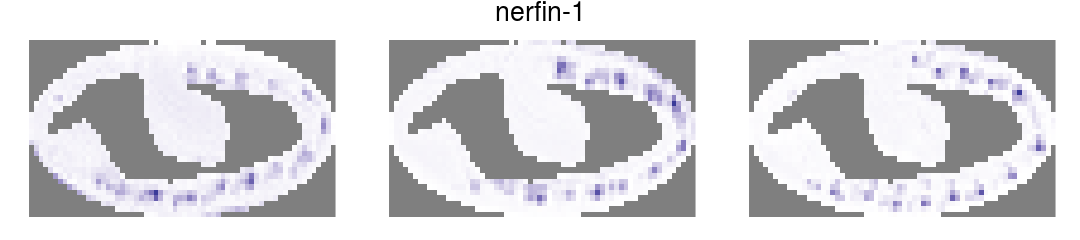

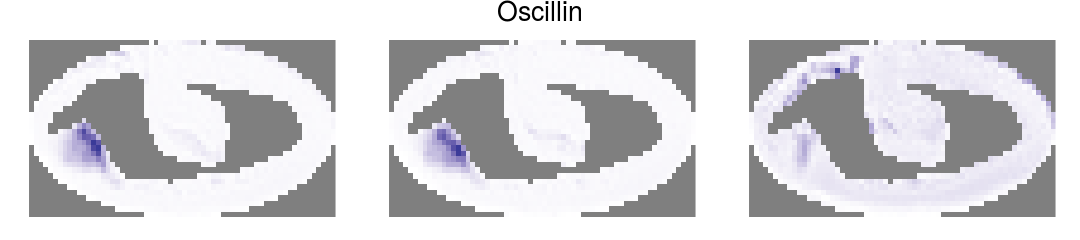

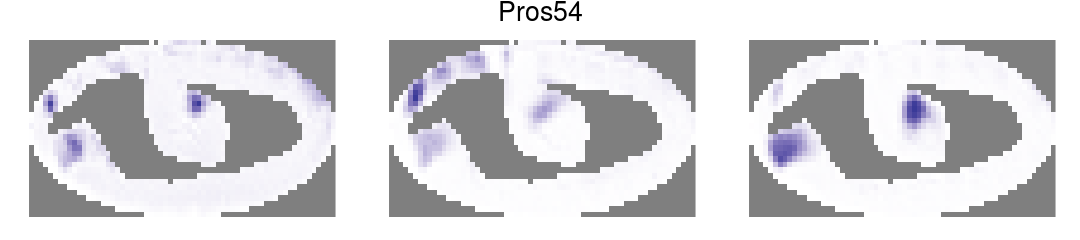

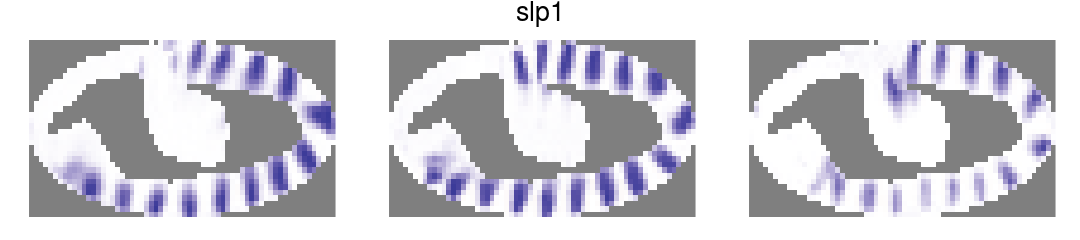

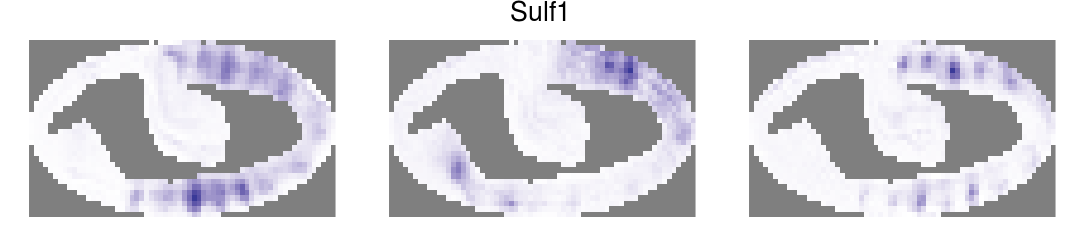

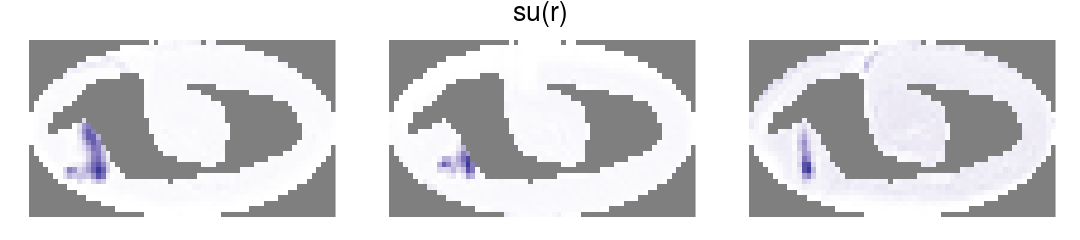

In [16]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) != 3){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 9, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


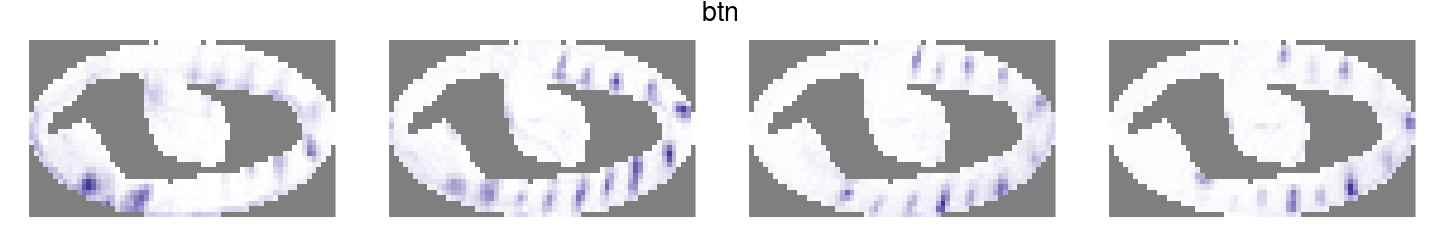

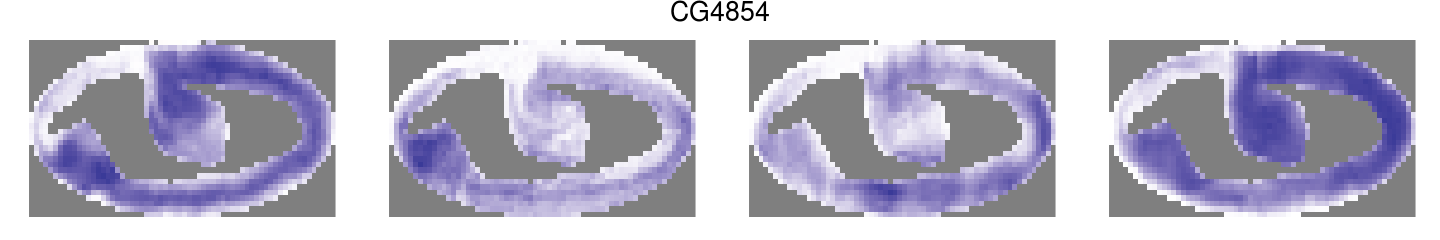

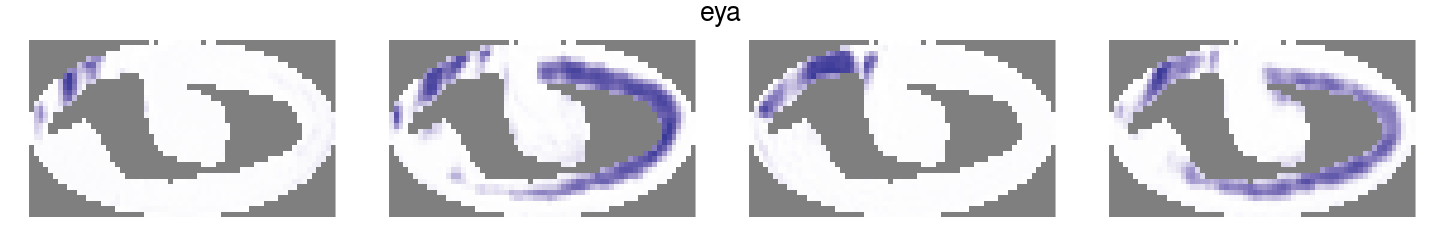

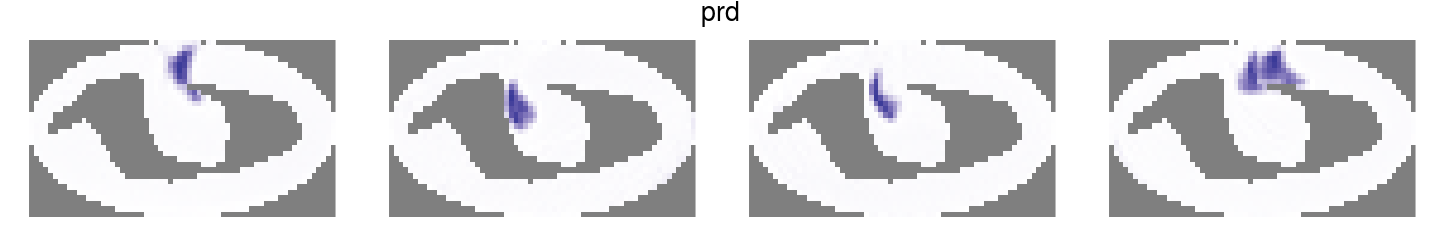

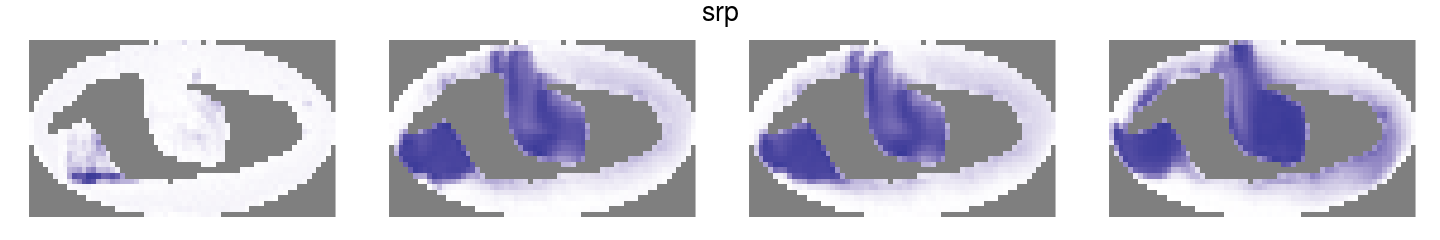

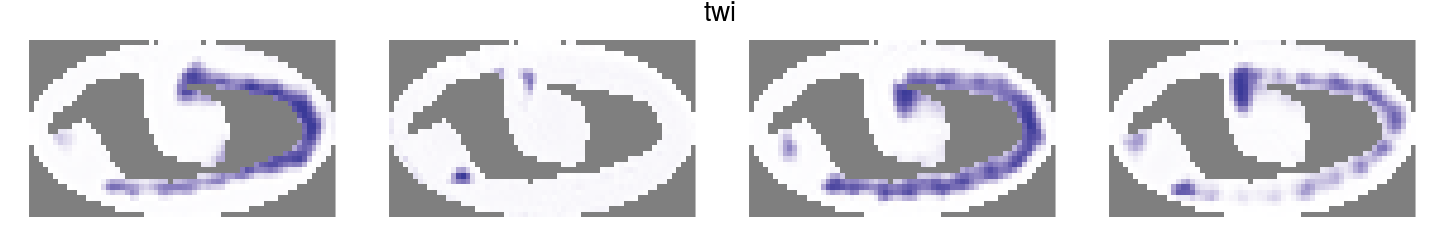

In [17]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) != 4){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 12, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


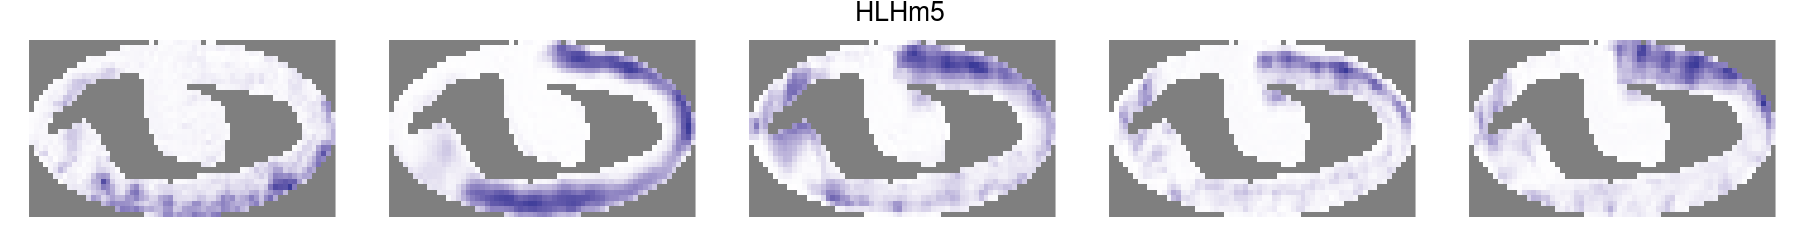

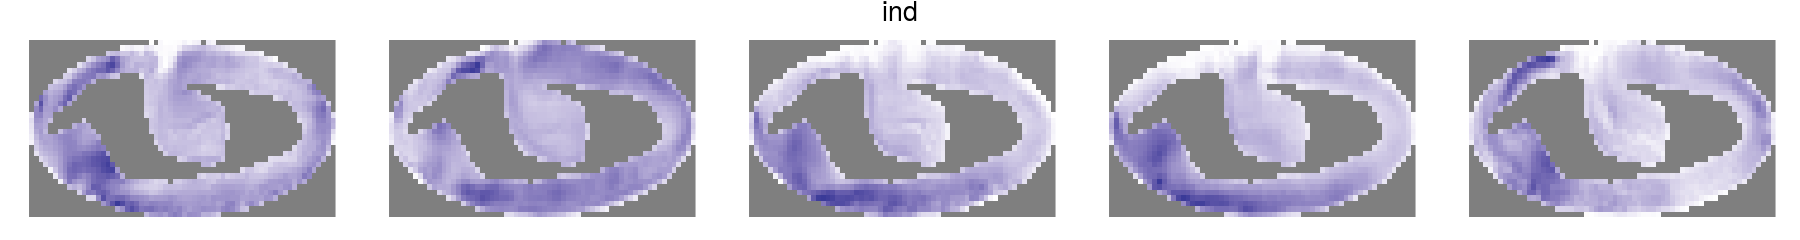

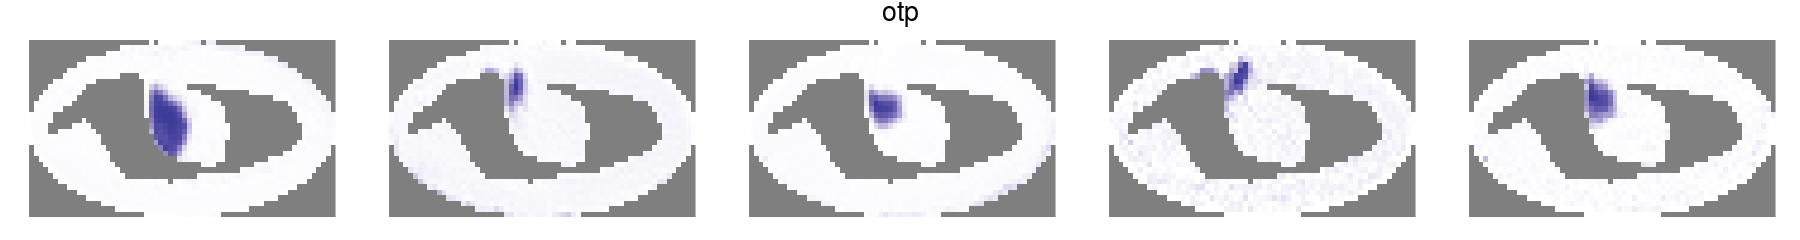

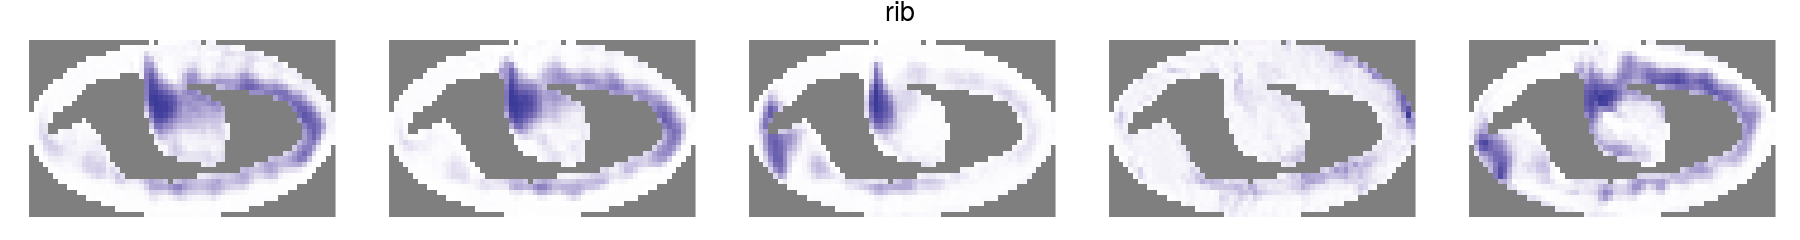

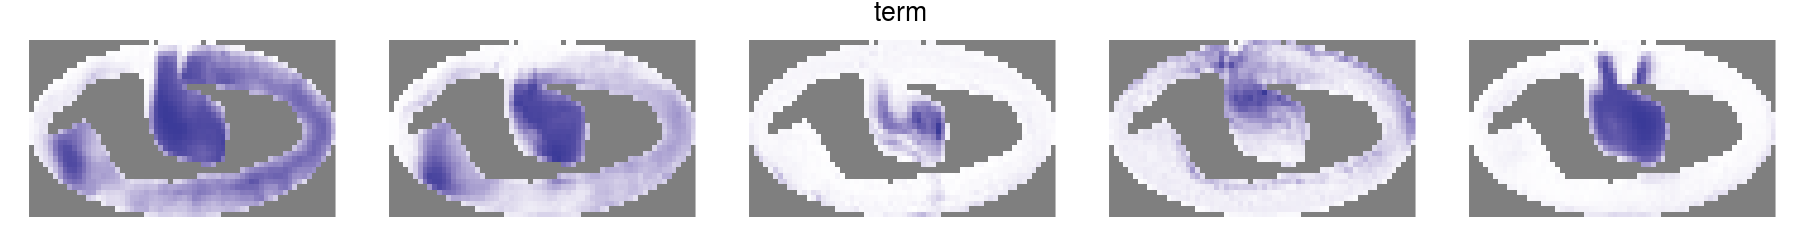

In [18]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) != 5){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 15, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


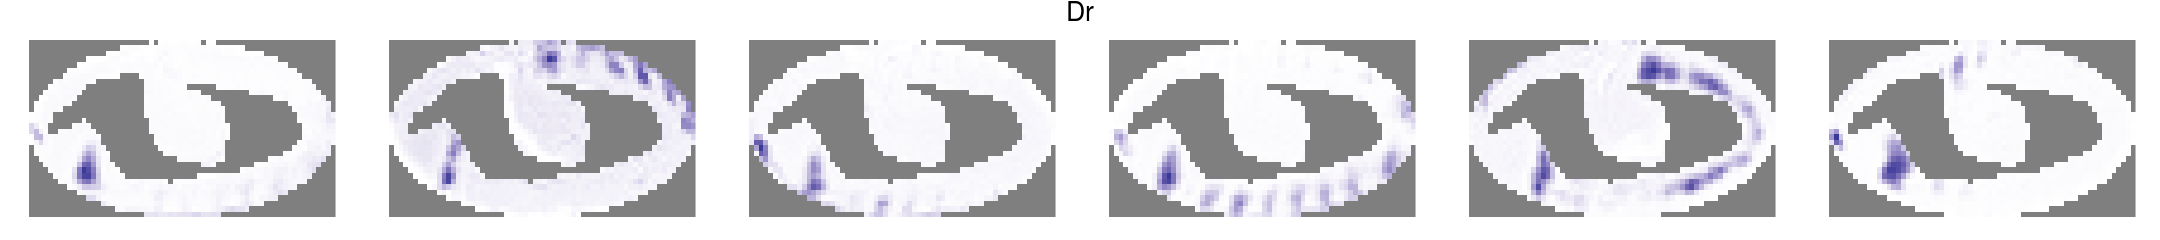

In [19]:
# plot gene
for(i in 1:length(which_problematic)){    
    gene <- which_problematic[i]
    indx <- which(late$gene.names == gene)
    
    if(length(indx) != 6){
        foo <- 1 
    }else{
        p <- list()

        for(i in 1:length(indx)){
            p[[i]] <- plotImg(late$x[, indx[i]], late$template, FALSE)    
        }

        options(repr.plot.width = 18, repr.plot.height = 2)
        multiplot(plotlist = p, cols = length(indx), title = gene)
    }
}


# Fix gene images according to recommendations by Erwin

There are a few possibilities: 

* The image was out of focus, and does not represent a real expression pattern; remove these replicates 

* For some genes, the expression of each replicate only captured a subset of the the true expression pattern; so here, we take either the max or average of the replicates

* The gene is actually dynamic in the late stage, and the different replicates were taken at slightly different points in time; here, the difference in replicates represent real variation. We append a letter "_a", "_b", "_c", etc and treat the replicates as different genes

In [20]:
# we store the clean images in clean_x
# keep only those which were not problematic
clean_x <- late$x[,  !(late$gene.names %in% which_problematic)]

In [21]:
dim(clean_x)

[1] 1143  601

In [22]:
# we go through each problematic gene, and apply Erwin's recommendation 

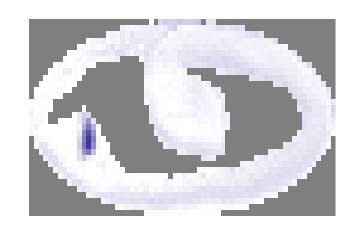

In [23]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Aldh'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'Aldh'

options(repr.plot.width = 3, repr.plot.height = 2)
plotImg(clean_x[, colnames(clean_x) == 'Aldh'], late$template, FALSE)    

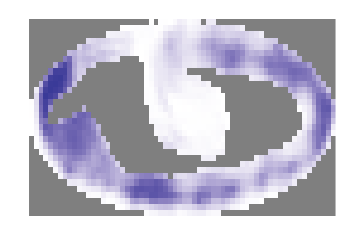

In [24]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Alhambra'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'Alhambra'

plotImg(clean_x[, colnames(clean_x) == 'Alhambra'], late$template, FALSE)    

In [25]:
foo <- late$x[, late$gene.names == 'Ance']
colnames(foo) <- c('Ance_1', 'Ance_2')
clean_x <- cbind(clean_x, foo)

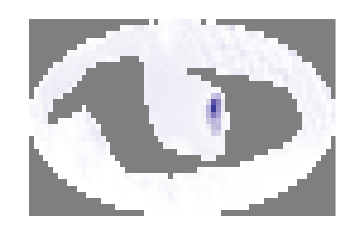

In [26]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'aret'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'aret'

plotImg(clean_x[, colnames(clean_x) == 'aret'], late$template, FALSE)    

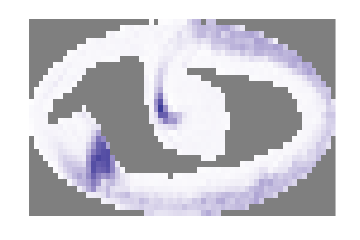

In [27]:
foo <- late$x[, late$gene.names == 'brk']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'brk'

plotImg(clean_x[, colnames(clean_x) == 'brk'], late$template, FALSE)    

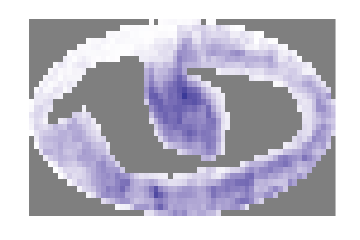

In [28]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG10053'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'CG10053'

plotImg(clean_x[, colnames(clean_x) == 'CG10053'], late$template, FALSE)    

In [29]:
# CG12744 CG12909 CG1598 are OK
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG12744'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG12909'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG1598'])

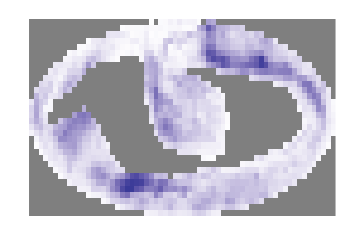

In [30]:
foo <- late$x[, late$gene.names == 'CG3184']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'CG3184'

plotImg(clean_x[, colnames(clean_x) == 'CG3184'], late$template, FALSE)    

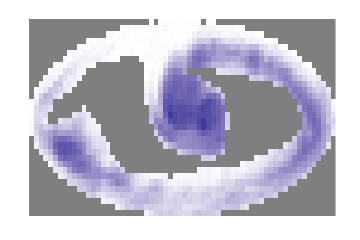

In [31]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG3249'][, 1])
colnames(clean_x)[dim(clean_x)[2]] <- 'CG3249'

plotImg(clean_x[, colnames(clean_x) == 'CG3249'], late$template, FALSE)    

In [32]:
foo <- late$x[, late$gene.names == 'CG3838']
colnames(foo) <- c('CG3838_1', 'CG3838_2')
clean_x <- cbind(clean_x, foo)

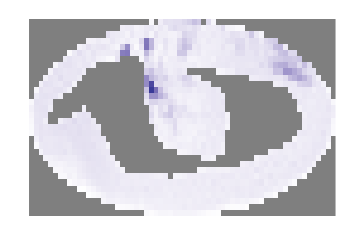

In [33]:
foo <- late$x[, late$gene.names == 'CG5888']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'CG5888'

plotImg(clean_x[, colnames(clean_x) == 'CG5888'], late$template, FALSE)    

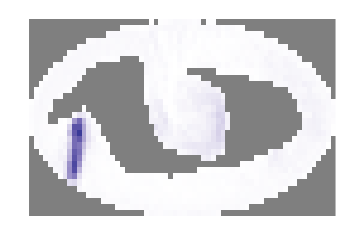

In [34]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG6070'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'CG6070'

plotImg(clean_x[, colnames(clean_x) == 'CG6070'], late$template, FALSE)    

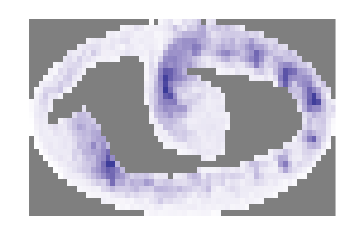

In [35]:
foo <- late$x[, late$gene.names == 'CG6206']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'CG6206'

plotImg(clean_x[, colnames(clean_x) == 'CG6206'], late$template, FALSE)    

In [36]:
foo <- late$x[, late$gene.names == 'CG6563']
colnames(foo) <- c('CG6563_1', 'CG6563_2')
clean_x <- cbind(clean_x, foo)

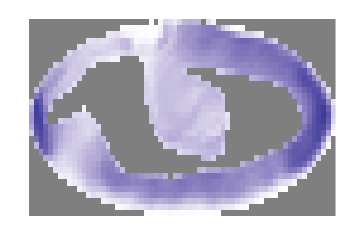

In [37]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'cic'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'cic'

plotImg(clean_x[, colnames(clean_x) == 'cic'], late$template, FALSE)    

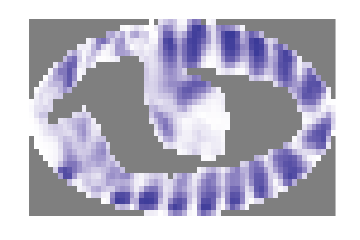

In [38]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'comm2'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'comm2'

plotImg(clean_x[, colnames(clean_x) == 'comm2'], late$template, FALSE)    

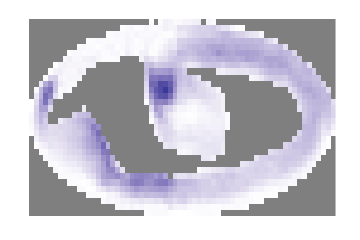

In [39]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'disco'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'disco'

plotImg(clean_x[, colnames(clean_x) == 'disco'], late$template, FALSE)    

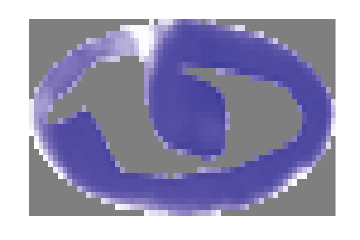

In [40]:
foo <- late$x[, late$gene.names == 'Dp']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'Dp'

plotImg(clean_x[, colnames(clean_x) == 'Dp'], late$template, FALSE)    

In [41]:
foo <- late$x[, late$gene.names == 'dpn']
colnames(foo) <- c('dpn_1', 'dpn_2')
clean_x <- cbind(clean_x, foo)

In [42]:
foo <- late$x[, late$gene.names == 'ebi']
colnames(foo) <- c('ebi_1', 'ebi_2')
clean_x <- cbind(clean_x, foo)

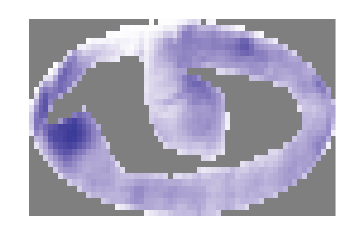

In [43]:
foo <- late$x[, late$gene.names == 'E(spl)']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'E(spl)'

plotImg(clean_x[, colnames(clean_x) == 'E(spl)'], late$template, FALSE)    

In [44]:
foo <- late$x[, late$gene.names == 'gcm']
colnames(foo) <- c('gcm_1', 'gcm_2')
clean_x <- cbind(clean_x, foo)

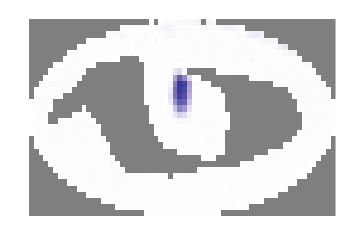

In [45]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Grip'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'Grip'

plotImg(clean_x[, colnames(clean_x) == 'Grip'], late$template, FALSE)    

In [46]:
foo <- late$x[, late$gene.names == 'HGTX']
colnames(foo) <- c('HGTX_1', 'HGTX_2')
clean_x <- cbind(clean_x, foo)

In [47]:
foo <- late$x[, late$gene.names == 'l(3)82Fd']
colnames(foo) <- c('l(3)82Fd_1', 'l(3)82Fd_2')
clean_x <- cbind(clean_x, foo)

In [48]:
foo <- late$x[, late$gene.names == 'lab']
colnames(foo) <- c('lab_1', 'lab_2')
clean_x <- cbind(clean_x, foo)

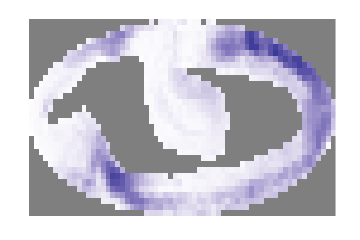

In [49]:
foo <- late$x[, late$gene.names == 'loner']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'loner'

plotImg(clean_x[, colnames(clean_x) == 'loner'], late$template, FALSE)    

In [50]:
foo <- late$x[, late$gene.names == 'mael']
colnames(foo) <- c('mael_1', 'mael_2')
clean_x <- cbind(clean_x, foo)

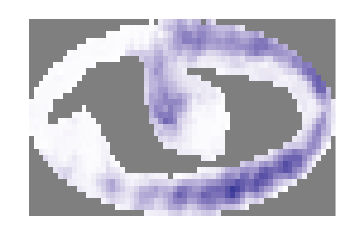

In [51]:
foo <- late$x[, late$gene.names == 'Mipp1']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'Mipp1'

plotImg(clean_x[, colnames(clean_x) == 'Mipp1'], late$template, FALSE)    

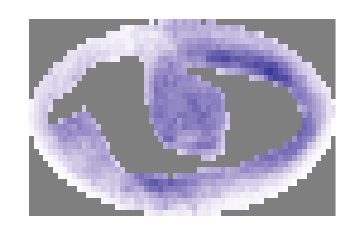

In [52]:
foo <- late$x[, late$gene.names == 'Nap1']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'Nap1'

plotImg(clean_x[, colnames(clean_x) == 'Nap1'], late$template, FALSE)    

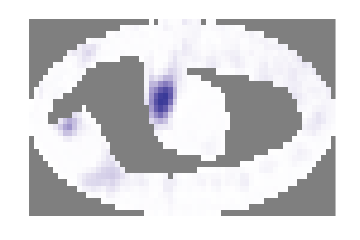

In [53]:
foo <- late$x[, late$gene.names == 'noc']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'noc'

plotImg(clean_x[, colnames(clean_x) == 'noc'], late$template, FALSE)    

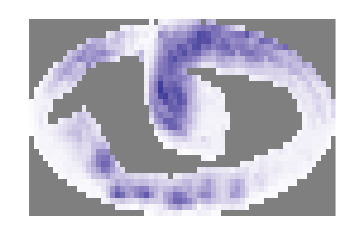

In [54]:
foo <- late$x[, late$gene.names == 'nrv2']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'nrv2'

plotImg(clean_x[, colnames(clean_x) == 'nrv2'], late$template, FALSE)    

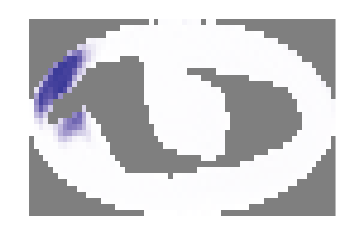

In [55]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Optix'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'Optix'

plotImg(clean_x[, colnames(clean_x) == 'Optix'], late$template, FALSE)    

In [56]:
# pnt is OK
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'pnt'])

In [57]:
foo <- late$x[, late$gene.names == 'sc']
colnames(foo) <- c('sc_1', 'sc_2')
clean_x <- cbind(clean_x, foo)

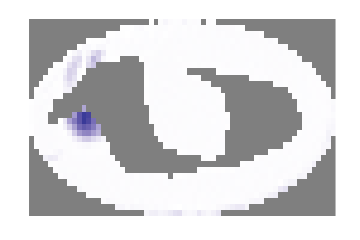

In [58]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'toy'][, 1])
colnames(clean_x)[dim(clean_x)[2]] <- 'toy'

plotImg(clean_x[, colnames(clean_x) == 'toy'], late$template, FALSE)    

In [59]:
foo <- late$x[, late$gene.names == 'ttk']
colnames(foo) <- c('ttk_1', 'ttk_2')
clean_x <- cbind(clean_x, foo)

In [60]:
foo <- late$x[, late$gene.names == 'tup']
colnames(foo) <- c('tup_1', 'tup_2')
clean_x <- cbind(clean_x, foo)

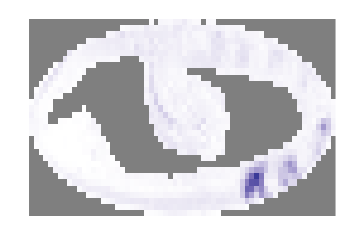

In [61]:
foo <- late$x[, late$gene.names == 'Ubx']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'Ubx'

plotImg(clean_x[, colnames(clean_x) == 'Ubx'], late$template, FALSE)    

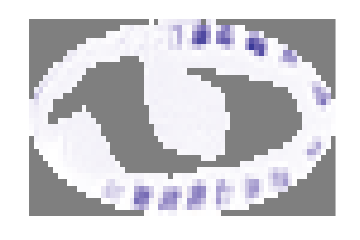

In [62]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'unpg'][, 1])
colnames(clean_x)[dim(clean_x)[2]] <- 'unpg'

plotImg(clean_x[, colnames(clean_x) == 'unpg'], late$template, FALSE)    

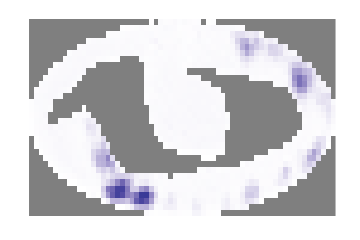

In [63]:
foo <- late$x[, late$gene.names == 'CG12489']

foo2 <- cbind(apply(foo[, c(1, 2)], 1, max), foo[, 3])

colnames(foo2) <- c('CG12489_1', 'CG12489_2')

clean_x <- cbind(clean_x, foo2)

plotImg(clean_x[, colnames(clean_x) == 'CG12489_1'], late$template, FALSE)    

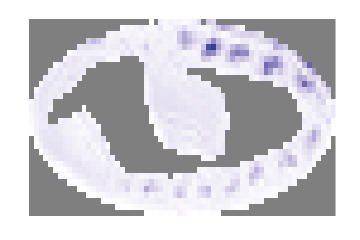

In [64]:
plotImg(clean_x[, colnames(clean_x) == 'CG12489_2'], late$template, FALSE)    

In [65]:
foo <- late$x[, late$gene.names == 'CG13624']
colnames(foo) <- c('CG13624_1', 'CG13624_2', 'CG13624_3')
clean_x <- cbind(clean_x, foo)

In [66]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG8066'][, c(1, 2)])

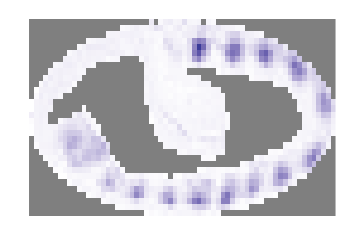

In [67]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG9663'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'CG9663'

plotImg(clean_x[, colnames(clean_x) == 'CG9663'], late$template, FALSE)    

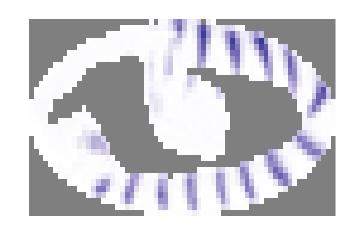

In [68]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'en'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'en'

plotImg(clean_x[, colnames(clean_x) == 'en'], late$template, FALSE)    

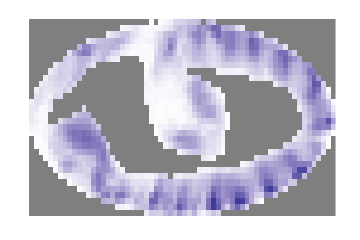

In [69]:
foo <- late$x[, late$gene.names == 'esg']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'esg'

plotImg(clean_x[, colnames(clean_x) == 'esg'], late$template, FALSE)    

In [70]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'ImpE2'][, c(1,2)])

In [71]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'inx2'][, c(1,2)])

In [72]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'kni'][, 1])
colnames(clean_x)[dim(clean_x)[2]] <- 'kni'

In [73]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Lac'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'Lac'

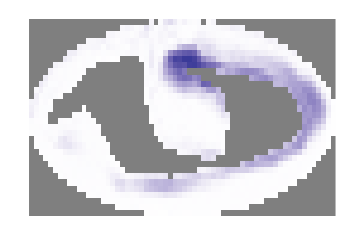

In [74]:
foo <- late$x[, late$gene.names == 'Mef2']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'Mef2'

plotImg(clean_x[, colnames(clean_x) == 'Mef2'], late$template, FALSE)    

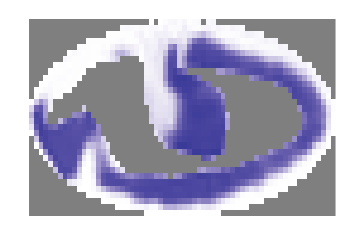

In [75]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Mes2'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'Mes2'

plotImg(clean_x[, colnames(clean_x) == 'Mes2'], late$template, FALSE)    

In [76]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'nerfin-1'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Oscillin'][, c(1,2)])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Pros54'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'slp1'])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'Sulf1'][, c(1, 3)])
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'su(r)'][, c(1, 3)])

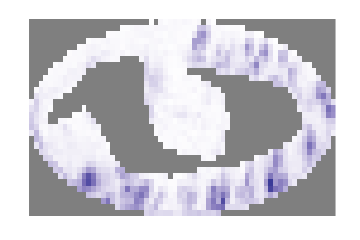

In [77]:
foo <- late$x[, late$gene.names == 'btn']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'btn'

plotImg(clean_x[, colnames(clean_x) == 'btn'], late$template, FALSE)    

In [78]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'CG4854'][, c(1, 4)])

In [79]:
# one set with two replicates
foo <- late$x[, late$gene.names == 'eya'][, c(1, 3)]
colnames(foo) <- c('eya_1', 'eya_1')

# another set with two replicates
foo2 <- late$x[, late$gene.names == 'eya'][, c(2, 4)]
colnames(foo2) <- c('eya_2', 'eya_2')

clean_x <- cbind(clean_x, foo, foo2)

In [80]:
foo <- late$x[, late$gene.names == 'prd'][, c(1,2,3)]
colnames(foo) <- c('prd_1', 'prd_2', 'prd_3')
clean_x <- cbind(clean_x, foo)

In [81]:
foo <- late$x[, late$gene.names == 'srp']
colnames(foo) <- c('srp_1', 'srp_2', 'srp_2', 'srp_2')

clean_x <- cbind(clean_x, foo)

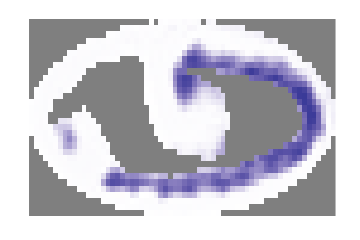

In [82]:
foo <- cbind(apply(late$x[, late$gene.names == 'twi'][, c(1, 3)], 1, max), 
             late$x[, late$gene.names == 'twi'][, 2])

colnames(foo) <- c('twi_1', 'twi_2')

clean_x <- cbind(clean_x, foo)

plotImg(clean_x[, colnames(clean_x) == 'twi_1'], late$template, FALSE)    

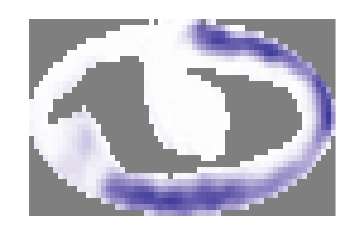

In [83]:
clean_x <- cbind(clean_x, late$x[, late$gene.names == 'HLHm5'][, 2])
colnames(clean_x)[dim(clean_x)[2]] <- 'HLHm5'

plotImg(clean_x[, colnames(clean_x) == 'HLHm5'], late$template, FALSE)    

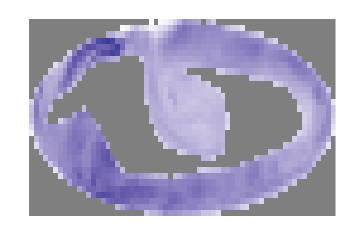

In [84]:
foo <- late$x[, late$gene.names == 'ind']
clean_x <- cbind(clean_x, apply(foo, 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'ind'

plotImg(clean_x[, colnames(clean_x) == 'ind'], late$template, FALSE)    

In [85]:
foo <- late$x[, late$gene.names == 'otp']
colnames(foo) <- c('otp_1', 'otp_2', 'otp_3', 'otp_4', 'otp_5')
clean_x <- cbind(clean_x, foo)

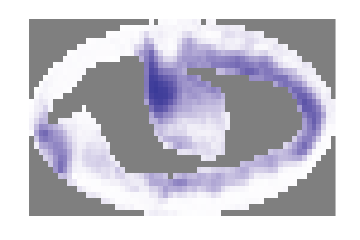

In [86]:
foo <- late$x[, late$gene.names == 'rib']
clean_x <- cbind(clean_x, apply(foo[, c(1, 2, 5)], 1, max))

colnames(clean_x)[dim(clean_x)[2]] <- 'rib'

plotImg(clean_x[, colnames(clean_x) == 'rib'], late$template, FALSE)    

In [87]:
foo <- late$x[, late$gene.names == 'term']
colnames(foo) <- c('term_1', 'term_1', 'term_2', 'term_3', 'term_4')
clean_x <- cbind(clean_x, foo)

In [88]:
foo <- late$x[, late$gene.names == 'Dr']

foo1 <- apply(foo[, c(2, 4)], 1, max)
foo2 <- apply(foo[, c(3, 5)], 1, max)
foo3 <- foo[, c(1, 6)]

foo4 <- cbind(foo1, foo2, foo3)

colnames(foo4) <- c('Dr_1', 'Dr_2', 'Dr_3', 'Dr_3')
clean_x <- cbind(clean_x, foo4)

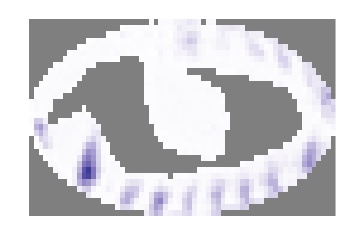

In [89]:
plotImg(clean_x[, colnames(clean_x) == 'Dr_1'], late$template, FALSE)    

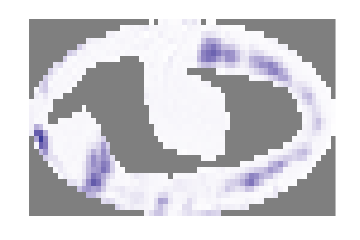

In [90]:
plotImg(clean_x[, colnames(clean_x) == 'Dr_2'], late$template, FALSE)    

In [91]:
dim(clean_x)

[1] 1143  726

In [92]:
dim(late$x)

[1] 1143  796

In [ ]:
# write.csv(clean_x, file = '../data/clean_x.csv')